# DataMapPlot Customizations

This notebook will walk you through some of the customization options that are available in DataMapPlot for making plots more distinctively your own. There are too many options availale to fully cover all that can be done, so this notebook will instead highlight some of the major options and hint at the further customization that can be achieved with respect to them. To get started we'll need to import DataMapPlot. Also, for the purposes of this documentation, I need to keep the image sizes smaller to fit in readthedocs; because of that I will set the global DPI for matplotlib (which DataMapPlot uses for plotting), but you should probably remove those lines if you are running this notebook yourself.

In [1]:
# Ensure we don't generate large images for inline docs
# You probably want to remove this if running the notebook yourself
import matplotlib

matplotlib.rcParams["figure.dpi"] = 72

import datamapplot

To demonstrate what DataMapPlot can do we'll need some data. The examples directory of the DataMapPlot repository contains some pre-prepared datasets for experimenting with. We'll grab one of those. In practice we need a data map -- as set of 2d coordinates, one per data sample we are mapping -- and a set of labels idenityfing the "topic" of a data sample, usually based on clusters in the data map. In this case we'll use data from the titles and abstracts of papers from the machine learning section of the ArXiv preprint server.

In [2]:
import numpy as np
import requests
import io

data_map_file = requests.get(
    "https://github.com/TutteInstitute/datamapplot/raw/main/examples/arxiv_ml_data_map.npy"
)
arxivml_data_map = np.load(io.BytesIO(data_map_file.content))
label_file = requests.get(
    "https://github.com/TutteInstitute/datamapplot/raw/main/examples/arxiv_ml_cluster_labels.npy"
)
arxivml_labels = np.load(io.BytesIO(label_file.content), allow_pickle=True)

Let's start by making the most basic DataMapPlot output based on this data so we have an idea of what the starting point looks like, and can better understand what the various customizations we will be applying can do for us.

(<Figure size 864x864 with 1 Axes>, <Axes: >)

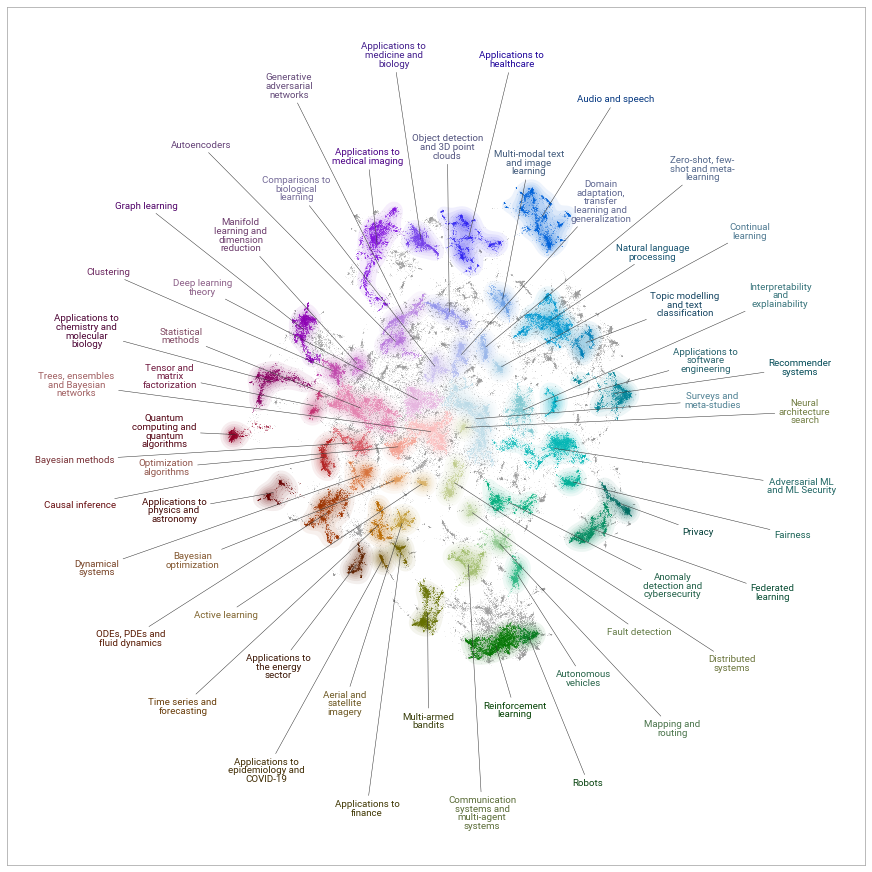

In [3]:
datamapplot.create_plot(arxivml_data_map, arxivml_labels)

The most basic thing you can do is to provide your plot with a title and, preferably, a sub-title. This can be done with the ``title`` and ``sub_title`` keyword arguments. DataMapPlot has default placement and formatting for the title an dsub-title that should be adequate for most needs. You can override this formatting using the ``title_keywords`` and ``sub_title_keywords`` options which take dictionaries of keyword arguments that will be passed through to matplotlib's ``suptitle`` and ``title`` ``fontdict`` arguments. See the matplotlib documentation on [suptitle](https://matplotlib.org/stable/api/figure_api.html#matplotlib.figure.Figure.suptitle) and [set_title](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.set_title.html#matplotlib.axes.Axes.set_title) for details of options that can be applied. In general the title should be short, while the sub-title can carry more information. If your title or sub-title get too long it will mess with the formatting, potentially in unpleasant ways. For our current data map we can use ``"ArXiv ML Landscape"`` as the title, and a slightly longer sub-title of ``"A data map of papers from the Machine Learning section of ArXiv"``.

(<Figure size 864x864 with 1 Axes>,
 <Axes: title={'left': 'A data map of papers from the Machine Learning section of ArXiv'}>)

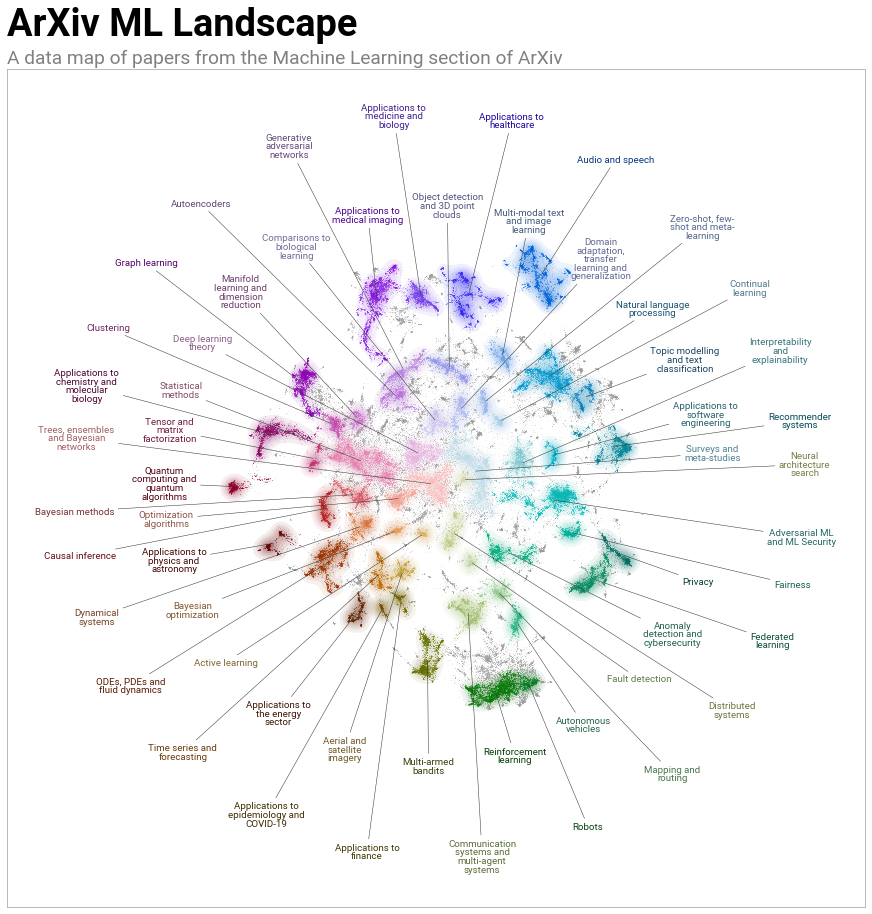

In [4]:
datamapplot.create_plot(
    arxivml_data_map,
    arxivml_labels,
    title="ArXiv ML Landscape",
    sub_title="A data map of papers from the Machine Learning section of ArXiv",
)

In presentations and posters branding matters, so being able to add the logo of your institution, university, or company to the plot likely matters to you. With that in mind DataMapPlot tries to make this relatively easy to do. First you'll need to get your logo in the right format, which is a numpy array. This can be done by simply calling ``np.asarray`` on a Python Image Library (PIL) image. To demonstrate this let's use the ArXiv logo which we can grab from wikimedia commons. In this case, since we are pulling directly from the internet we will stream the result directly to ``PIL.Image.open``, but if you have an image file (in any reasonable format) you can simply pass the path to the file to ``PIL.Image.open`` and it should work just as well.

In [5]:
import PIL

arxiv_logo_response = requests.get(
    "https://upload.wikimedia.org/wikipedia/commons/thumb/b/bc/ArXiv_logo_2022.svg/320px-ArXiv_logo_2022.svg.png",
    stream=True,
    headers={"User-Agent": "My User Agent 1.0"},
)
arxiv_logo = np.asarray(PIL.Image.open(arxiv_logo_response.raw))

Having gotten a logo image ready for use we simply provide the numpy array to the ``logo`` keyword argument in ``create_plot``. The logo will then be placed in the bottom right of the plot. You can control the size of the logo with the ``logo_width`` keyword argument which specifies the width as a fraction of the total figure width. The aspect ratio of the image will be preserved by this scaling. You can adjust the size accordingly to make your image fit as you wish.

(<Figure size 864x864 with 1 Axes>,
 <Axes: title={'left': 'A data map of papers from the Machine Learning section of ArXiv'}>)

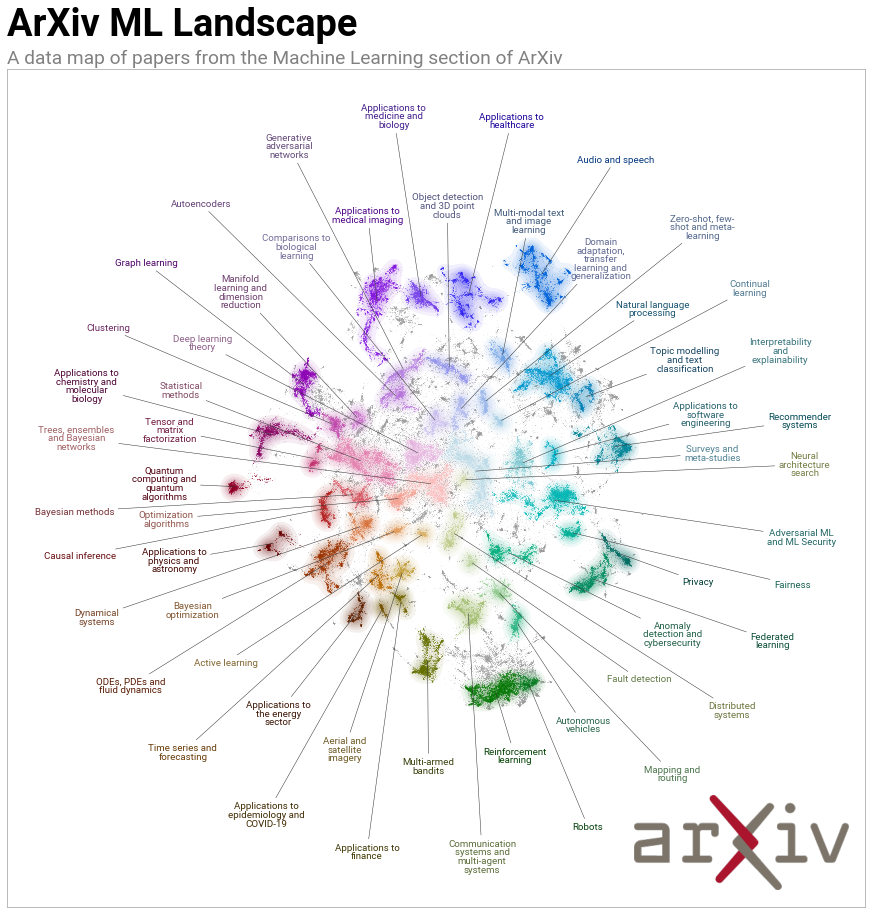

In [6]:
datamapplot.create_plot(
    arxivml_data_map,
    arxivml_labels,
    title="ArXiv ML Landscape",
    sub_title="A data map of papers from the Machine Learning section of ArXiv",
    logo=arxiv_logo,
    logo_width=0.25,
)

If you need more complicated logo formatting or placement than is available via the simple options DataMapPlot provides then keep in mind that, since DataMapPlot simply returns matplotlib ``Figure`` and ``Axes`` objects, you can use further matplotlib do whatever custom image sizing andplacement you require -- it just might be a little more complicated.

The default font for DataMapPlot is DejaVu Sans since this can be assumed to be largely universally available and covers the widest swathe of unicode for such a widely available free font. Of course DejaVu Sans is a pretty basic font and may not meet your needs, especially if your institution of company has preferred fonts that it uses in branding or marketing. Fortunately DataMapPlot has good support for working with other fonts -- as long as those fonts are available to matplotlib. To keep the tutorial universal we'll use a little helper function that can fetch fonts from Google fonts and install them so they are available to matplotlib (within this session). If you have your own fonts that you wish to use you either need to ensure they are available as system fonts, or add them to matplotlib similarly to what is done below.

In [7]:
import matplotlib.font_manager
from tempfile import NamedTemporaryFile
from fontTools import ttLib
import re


def get_google_font(fontname):
    api_fontname = fontname.replace(" ", "+")
    api_response = resp = requests.get(
        f"https://fonts.googleapis.com/css?family={api_fontname}:black,bold,regular,light"
    )
    font_urls = re.findall(r"(https?://[^\)]+)", str(api_response.content))
    for font_url in font_urls:
        font_data = requests.get(font_url)
        f = NamedTemporaryFile(delete=False, suffix=".ttf")
        f.write(font_data.content)
        f.close()
        font = ttLib.TTFont(f.name)
        font_family_name = font["name"].getDebugName(1)
        matplotlib.font_manager.fontManager.addfont(f.name)
        print(f"Added new font as {font_family_name}")


get_google_font("Marcellus SC")
get_google_font("Great Vibes")

Added new font as Marcellus SC
Added new font as Great Vibes


Now that we have acquired some more interesting fonts, let's see what we can do. The most basic option is to universally set a font family for the plot, which can be done via the ``fontfamily`` keyword argument to ``create_plot``. This will set the font for the labels as well as for the title and sub-title (unless you have specifically overridden those). This makes it easy to keep a consistent font choice throuhgout. Here we'll use the "Great Vibes" font, an elegant script style font that is not the best for readability, but quite attractive.

(<Figure size 864x864 with 1 Axes>,
 <Axes: title={'left': 'A data map of papers from the Machine Learning section of Arxiv'}>)

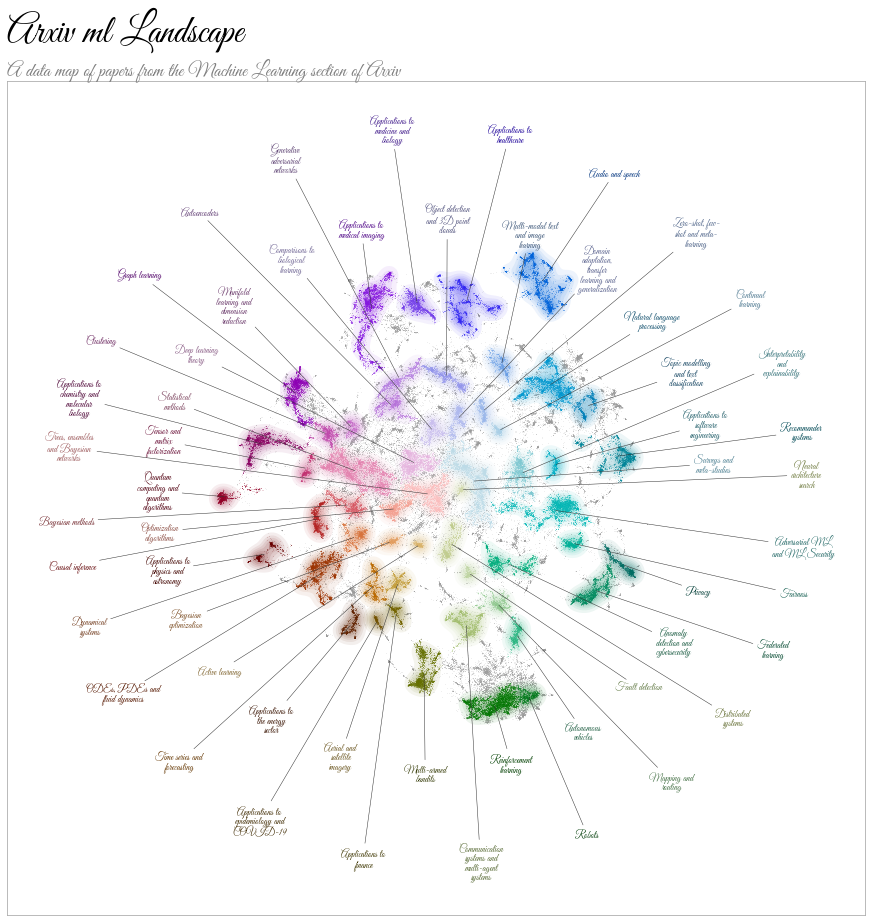

In [8]:
datamapplot.create_plot(
    arxivml_data_map,
    arxivml_labels,
    title="Arxiv ml Landscape",
    sub_title="A data map of papers from the Machine Learning section of Arxiv",
    font_family="Great Vibes",
)

Alteratibely we could use the "Marcellus SC" font, whcih is a "small caps" font with generally good readability, but a little more flair than DejaVu Sans.

(<Figure size 864x864 with 1 Axes>,
 <Axes: title={'left': 'A data map of papers from the Machine Learning section of ArXiv'}>)

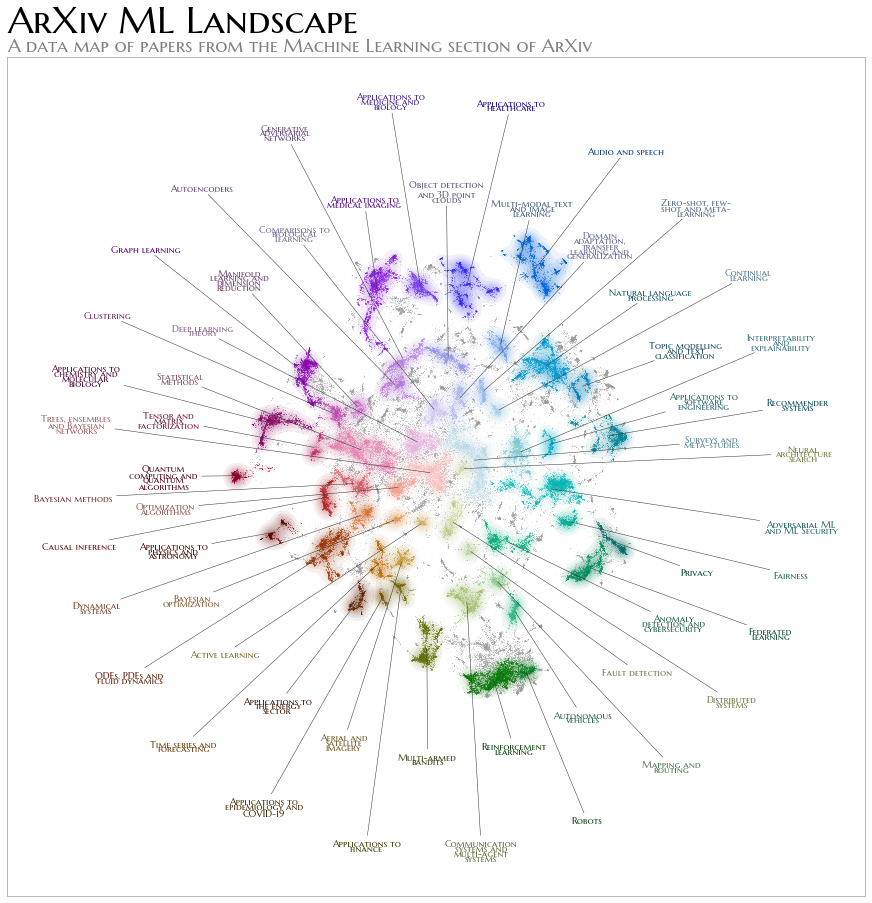

In [9]:
datamapplot.create_plot(
    arxivml_data_map,
    arxivml_labels,
    title="ArXiv ML Landscape",
    sub_title="A data map of papers from the Machine Learning section of ArXiv",
    font_family="Marcellus SC",
)

At this point we should note a problem: by default DataMapPlot keeps a small lineheight to keep multi-line label text fairly compact, but in this case it has overcompacted it. We can fix this by specifically setting the label_linespacing. In this case if we crank it up to 1.25 to spread the lines out a little more we'll get a better looking result.

(<Figure size 864x864 with 1 Axes>,
 <Axes: title={'left': 'A data map of papers from the Machine Learning section of ArXiv'}>)

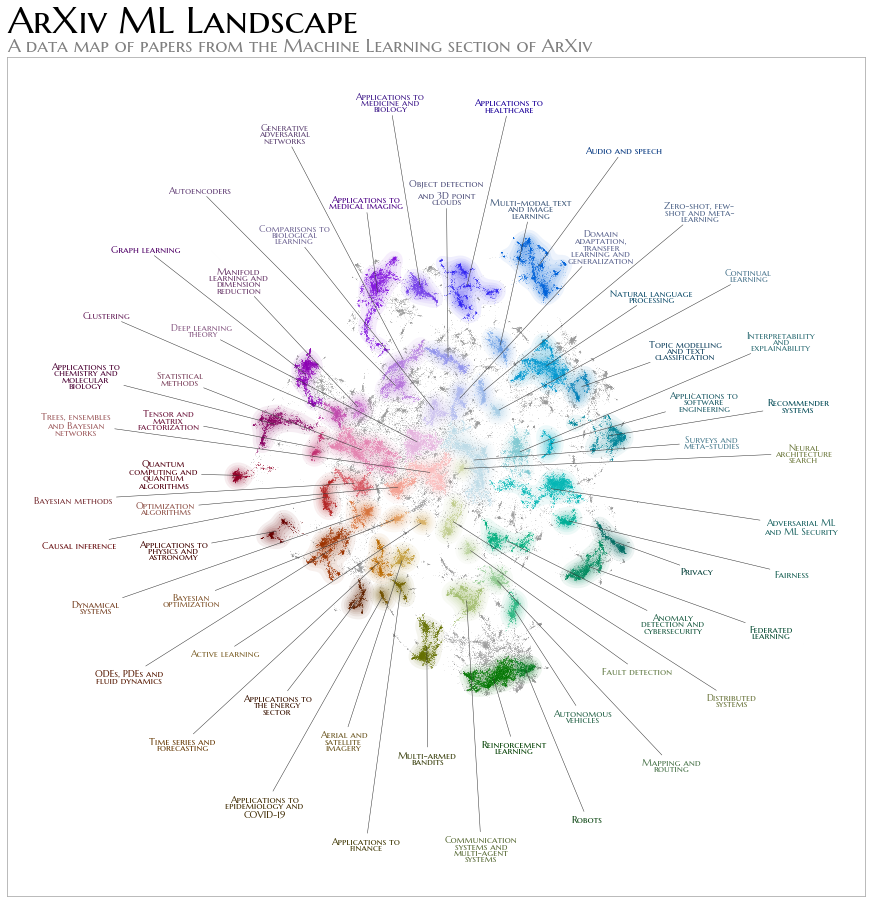

In [10]:
datamapplot.create_plot(
    arxivml_data_map,
    arxivml_labels,
    title="ArXiv ML Landscape",
    sub_title="A data map of papers from the Machine Learning section of ArXiv",
    font_family="Marcellus SC",
    label_linespacing=1.25,
)

Another item that can potentially be re-styled to provide a more unique look is the indicator lines from the text labels to the clusters they are labelling. A first option, particularly useful if your clusters are not compact (or not connected), is to use the ``use_medoids`` keyword argument, which chooses where the indicator points from the centroid of the cluster to the medoid. The centroid may not always be the best indicator position for non-compact clusters; in contrast the medoid is guaranteed to be a point actualkly in the cluster and will thus provide a better representative in such cases. Since medoids can be computationally expensive to compute this is not the default option.

Besides where the indicator points we can also style the indicator itself. In practice these are provided via matplotlibs [``annotate``](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.annotate.html#matplotlib.axes.Axes.annotate), and the indicator lines can be controlled via the ``arrowprops`` keyword, which will be passed along to annotate to handle the arrow style. In practice matplotlib arrows support a great deal of options, which extend well beyond the scope of this tutorial. I would suggest you consult the excellent [matplotlib documentation](https://matplotlib.org/stable/users/explain/text/annotations.html#customizing-annotation-arrows) on customizing annotation arrows. To give some idea of what is possible let's use a fancy arrow style (a "wedge"), use a connection style that has some arc to it (with a small ``rad=0.05`` deviation from straight), no edges and non-standard and semi-transparent face-color. This should give you some idea of the kinds of things that are possible.

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


(<Figure size 864x864 with 1 Axes>, <Axes: >)

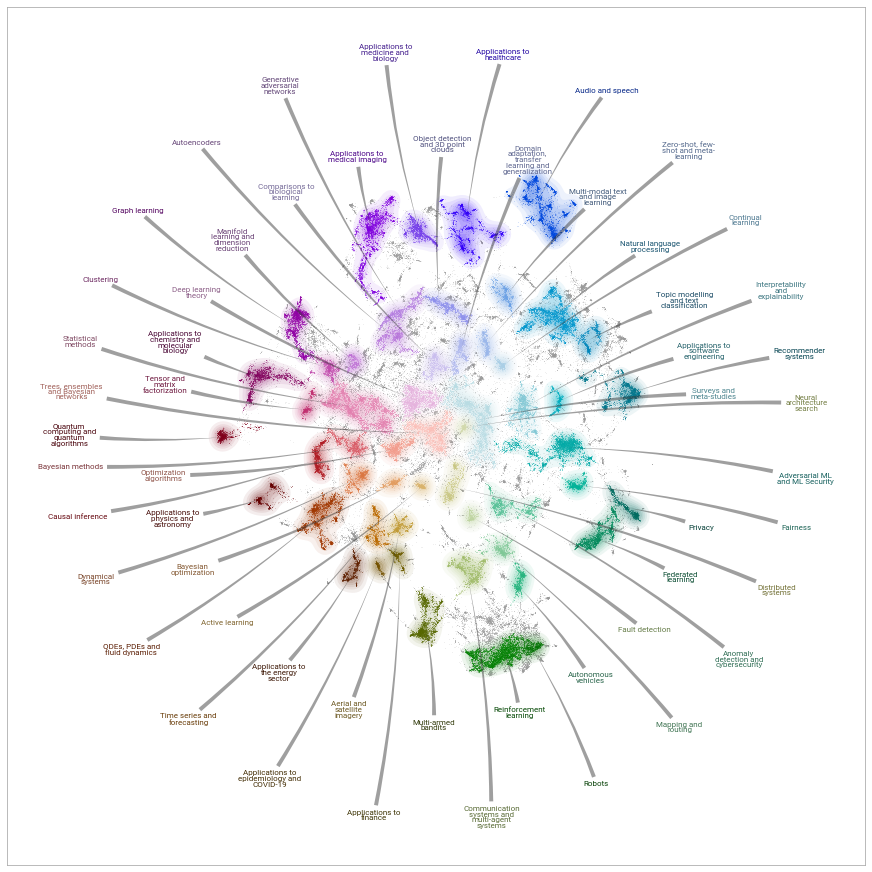

In [11]:
datamapplot.create_plot(
    arxivml_data_map,
    arxivml_labels,
    label_font_size=8,
    use_medoids=True,
    arrowprops={
        "arrowstyle": "wedge,tail_width=0.5",
        "connectionstyle": "arc3,rad=0.05",
        "linewidth": 0,
        "fc": "#33333377",
    },
)

Another common situation is needing to highlight some of the labels that are of particular importance. This can be especially important if a small subset of labels are relevant to the point you are making, but y6ou need the larger context of all the labels to make that point clear. DataMapPlot comes with a basic facility for highlighting specific labels. At it's most basic you can do this via the ``highlight_labels`` keyword which takes a list of text labels to be highlighted. Note that these labels need to match the exact text from your labels array that you are passing in. By default ``create_plot` will simply set the highlighted labels in a bold font. For the ArXiv ML example some of the topics that I care about include clustering, manifold learning, topic modelling, and active learning. We can pass the relevant labels to ``highlight_labels`` and let it handle th rest.

(<Figure size 864x864 with 1 Axes>, <Axes: >)

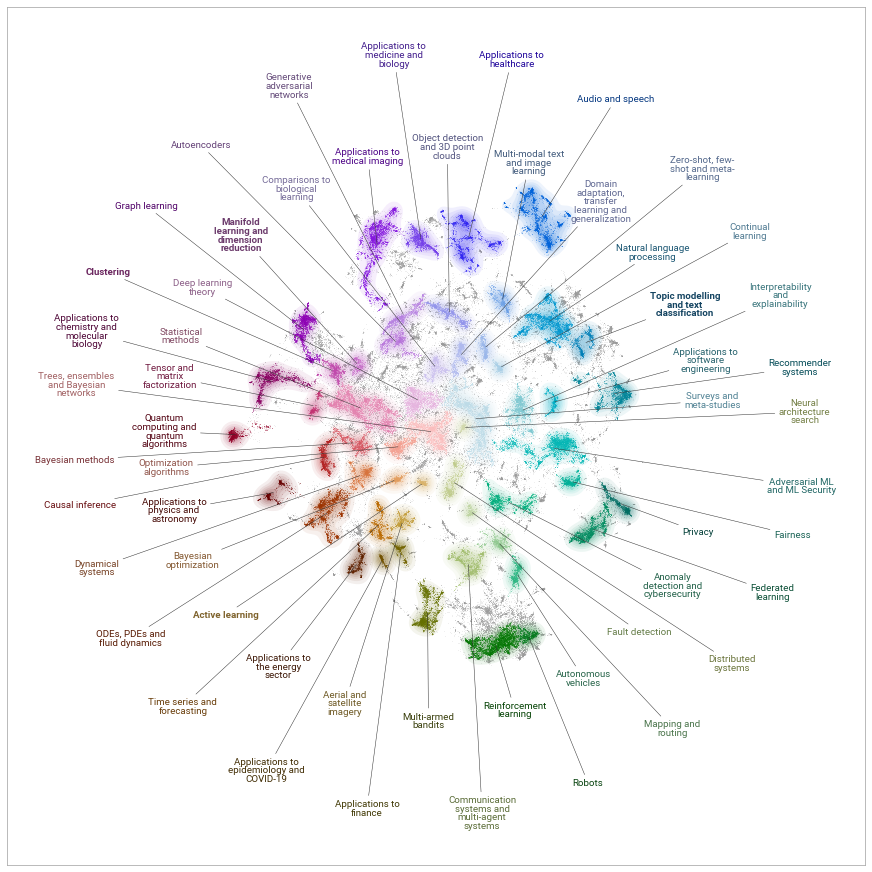

In [12]:
datamapplot.create_plot(
    arxivml_data_map,
    arxivml_labels,
    highlight_labels=[
        "Clustering",
        "Manifold learning and dimension reduction",
        "Active learning",
        "Topic modelling and text classification",
    ],
)

Perhaps that doesn't make the labels stand out enough for your use case? In this case, because there are so many labels in the plot, it can be a little hard to see which labels are highlighted simply based on bolding the text. Fortunately we can also specify ``highlight_label_keywords`` that can take a dictionary of keyword arguments to be applied when styling the labels. We can, for example, set the fontsize and fontweight (and potentially even the fontfamily) differently for the highlighted labels. Since we are using matplotlib's ``annotate`` function we can also add bounding box information via the ``bbox`` keyword argument. Consult the [matplotlib documentation](https://matplotlib.org/stable/users/explain/text/annotations.html#annotating-with-boxed-text) on bounding boxes for text for all the myriad options available. Here we will use a round boxstyle to put highlight boxes around the highlighted labels, making them stand out more.

(<Figure size 864x864 with 1 Axes>, <Axes: >)

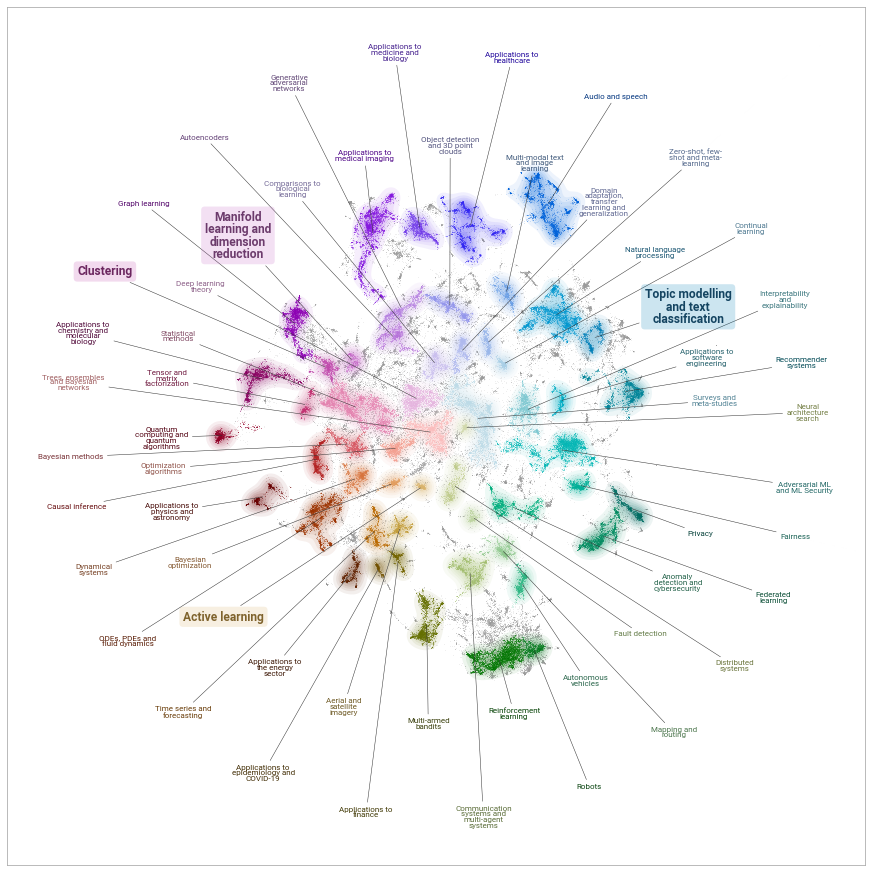

In [13]:
datamapplot.create_plot(
    arxivml_data_map,
    arxivml_labels,
    highlight_labels=[
        "Clustering",
        "Manifold learning and dimension reduction",
        "Active learning",
        "Topic modelling and text classification",
    ],
    label_font_size=8,
    highlight_label_keywords={
        "fontsize": 12,
        "fontweight": "black",
        "bbox": {"boxstyle": "round"},
    },
)

Putting much of this customization together we can create a relatively compelling plot, with a little branding, and highlighting the points of interest that we wish to draw attention to:

(<Figure size 864x864 with 1 Axes>,
 <Axes: title={'left': 'A data map of papers from the Machine Learning section of ArXiv'}>)

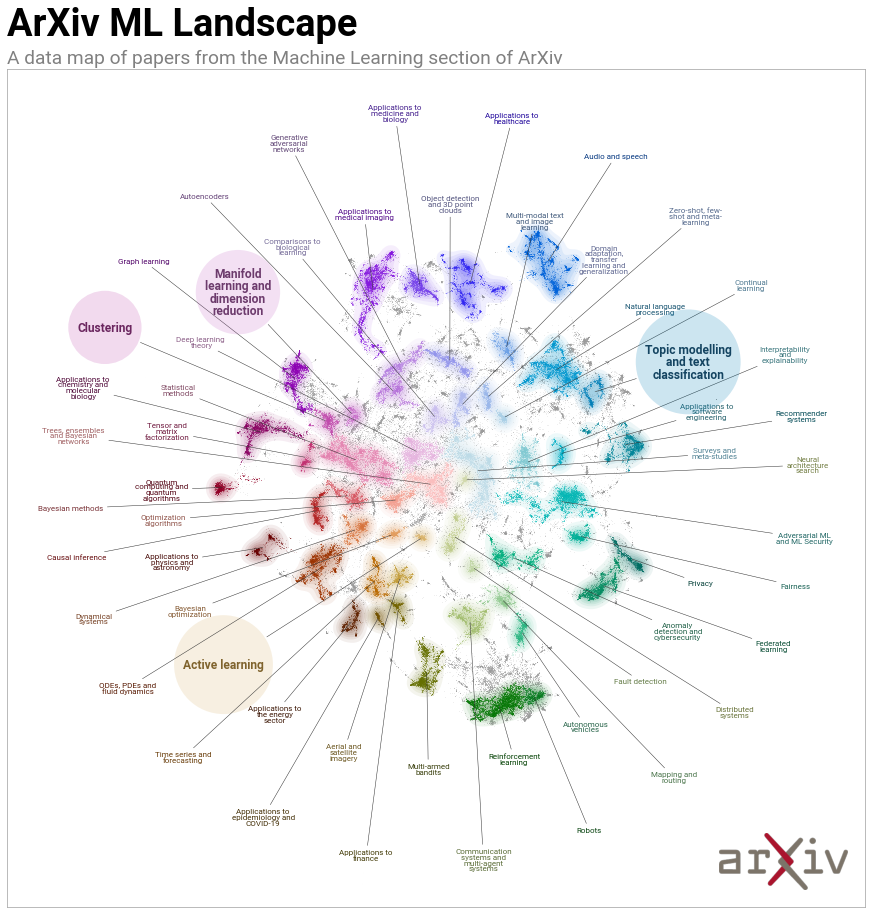

In [14]:
datamapplot.create_plot(
    arxivml_data_map,
    arxivml_labels,
    title="ArXiv ML Landscape",
    sub_title="A data map of papers from the Machine Learning section of ArXiv",
    highlight_labels=[
        "Clustering",
        "Manifold learning and dimension reduction",
        "Active learning",
        "Topic modelling and text classification",
    ],
    label_font_size=8,
    highlight_label_keywords={
        "fontsize": 12,
        "fontweight": "bold",
        "bbox": {"boxstyle": "circle", "pad": 0.75},
    },
    logo=arxiv_logo,
)

There are, of course, many more options, but this covers the basics. Dig into the API reference for more details about the options available within DataMapPlot. If you need even further customization still then please refer to the [matplotlib documentation](https://matplotlib.org/stable/users/index.html) for all the things you can do to and with the ``Figure`` and ``Axes`` objects returned by DataMapPlot -- you can do whatever further syiling you wish via standard matplotlib operations.